## Atmospheric River Detection Testing

In [32]:
import xarray as xr
import hvplot.xarray
import hvplot.pandas
from datetime import datetime
from scipy.ndimage import label, generate_binary_structure, labeled_comprehension
from skimage.measure import regionprops


from config import ar_params, ard_fp
#from ar_detection import *

Check AR detection parameters imported from ```config.py```. See the ```config.py``` for more detailed description of these parameters.

In [2]:
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 1000}

**Note:** we are using 1000km for the minimum AR length during this test, since using 2000km from Guan & Waliser would require downloading a much larger spatial domain. Also, the 2:1 minimum length to width ratio has been hashed out in the ```filter_regions_by_geometry()``` function; without the full length of the AR to compute this criteria, some AR events were being dropped erroneously. 

For this testing phase, a bounding box of [60, -150, 50, -130] was used. Once development of these functions is complete, a larger spatial domain should be downloaded and the parameters/functions mentioned above should be updated.

Open the dataset resulting from the ```compute_ivt.py``` script, using the ```ard_fp``` variable imported from ```config.py```. Alternatively, reset the ```ard_fp``` variable to an explicit test dataset.

In [3]:
ds = xr.open_dataset(ard_fp)
ds

<xarray.Dataset>
Dimensions:                  (time: 5844, latitude: 41, longitude: 81, doy: 366)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-01 ... 2022-12-31T...
  * doy                      (doy) int32 1 2 3 4 5 6 ... 361 362 363 364 365 366
  * longitude                (longitude) float32 -150.0 -149.8 ... -130.2 -130.0
  * latitude                 (latitude) float32 60.0 59.75 59.5 ... 50.25 50.0
Data variables:
    p71.162                  (time, latitude, longitude) float32 ...
    p72.162                  (time, latitude, longitude) float32 ...
    ivt_mag                  (time, latitude, longitude) int32 ...
    ivt_dir                  (time, latitude, longitude) int32 ...
    ivt_seasonal_quantile    (time, latitude, longitude) float64 ...
    ivt_por_normal_quantile  (doy, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-12 18:18:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Examine a known atmospheric river event (Haines 2020).

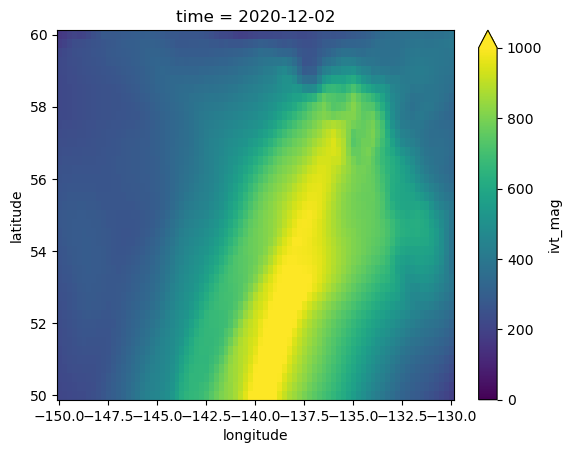

In [18]:
test_haines_date = "2020-12-02T00:00:00"
# get the actual IVT magnitude for this time
haines_ivt_mag = ds["ivt_mag"].sel(time=test_haines_date)
haines_ivt_mag.plot(vmin=0, vmax=1000)

In [19]:
# what is the DOY for our test date?
datetime_obj = datetime.fromisoformat(test_haines_date)
test_doy = datetime_obj.timetuple().tm_yday
test_doy

337

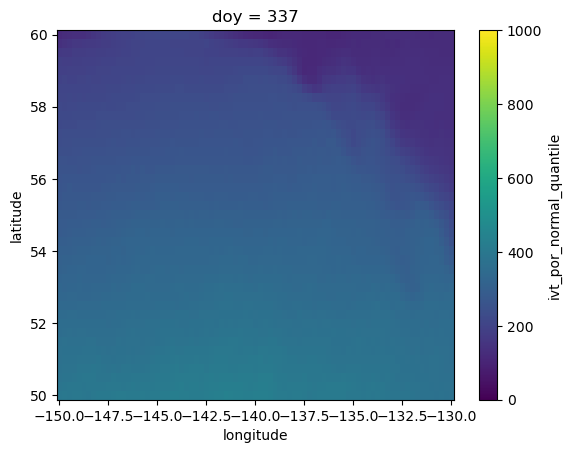

In [20]:
haines_ivt_85th_normal_percentile = ds["ivt_por_normal_quantile"].sel(doy=test_doy)
haines_ivt_85th_normal_percentile.plot(vmin=0, vmax=1000)

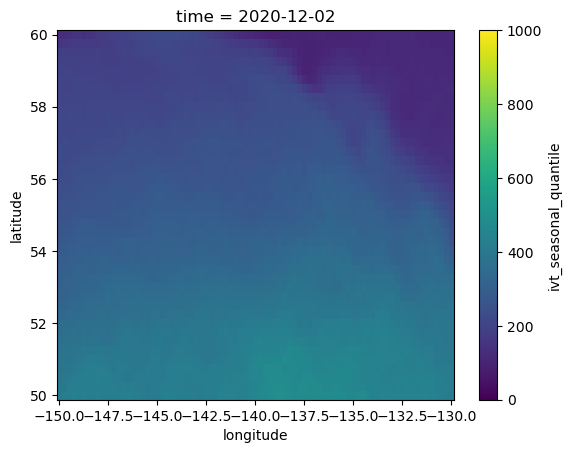

In [21]:
haines_ivt_85th_seasonal_percentile = ds["ivt_seasonal_quantile"].sel(time=test_haines_date)
haines_ivt_85th_seasonal_percentile.plot(vmin=0, vmax=1000)

Compute intensity mask and create new variable in the dataset.

In [8]:
# IVT intensity masking
# use to identify where IVT magnitude > IVT percentile and IVT magnitude > IVT floor
# values meeting criteria will keep their IVT magnitude values
# values not meeting criteria will be assigned NA
def intensity_mask(ivt_mag, ivt_pctile, ivt_floor):
    func = lambda x, y, z: xr.where((x>y) & (x>z), x, 0)
    return xr.apply_ufunc(func, ivt_mag, ivt_pctile, ivt_floor, dask='parallelized')


In [46]:
thresholded = intensity_mask(haines_ivt_mag, haines_ivt_85th_normal_percentile, 400)

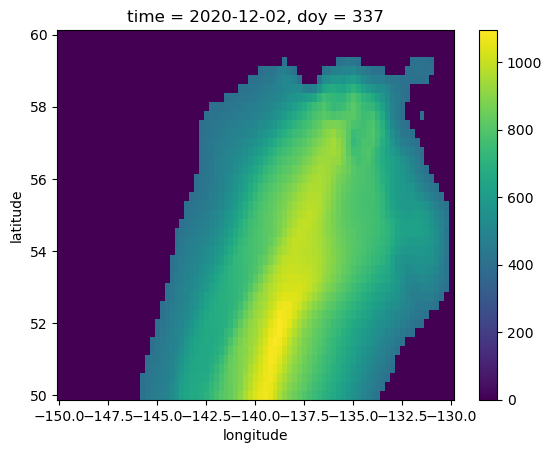

In [47]:
thresholded.plot()

This image may be more striking with a bigger domain.

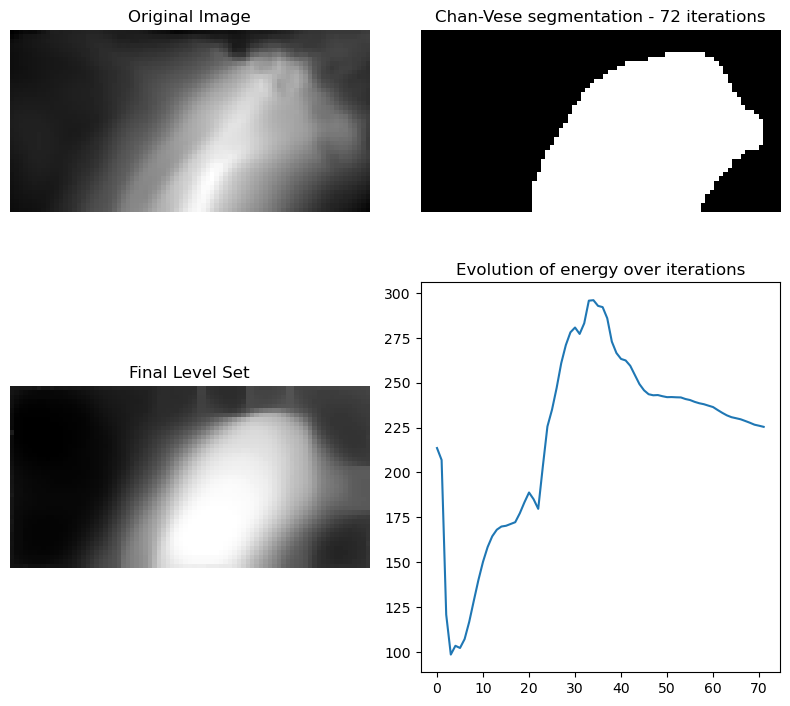

In [52]:
from skimage.segmentation import chan_vese

image = haines_ivt_mag.data
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.5, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

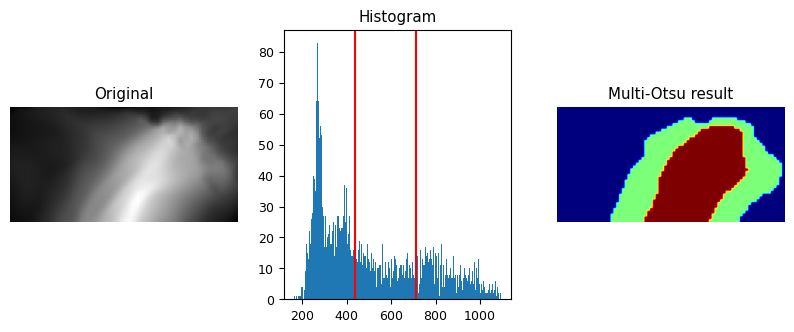

In [55]:
from skimage.filters import threshold_multiotsu
import matplotlib
import numpy as np
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()


This is a lot like the snowdrift-finding problem - where is the concentration of water? Edges are fuzzy, and there is a consistent shape, but many variations within that shape, and shapes evolve over time. 

Label regions and create new variable in the dataset.

In [34]:
s = generate_binary_structure(2, 2)
s

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [35]:
labeled_array, num_features = label(thresholded.values, structure=s)


In [37]:
labeled_array

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [38]:
num_features

1

In [ ]:
ds["regions"] = label_regions(ds["intensity_mask"])

Filter regions by geometric criteria. (This function alters the dataset in place; the output dictionary is just a reference used for confirming bad labels are dropped.)

In [ ]:
geo_drop_dict = filter_regions_by_geometry(ds['regions'], ar_params['min_axis_length'])

### plotting

Check out IVT magnitude, IVT percentile, and labeled AR regions in two interactive viewers. The Haines AR event was on Dec 1 and 2, 2020.

In [ ]:
ds['ivt_mag'].hvplot(groupby='time', x = 'longitude', y = 'latitude', width=600, widget_type='scrubber', widget_location='right', clim=(0, 800))

In [ ]:
ds['regions'].hvplot(groupby='time', x = 'longitude', y = 'latitude', width=600, widget_type='scrubber', widget_location='right', clim=(0, 4))

### unfinished testing

Testing of ```filter_regions_by_direction()``` function. This is incomplete and currently just prints a list of ```ivt_dir``` values for each labeled region. See ```ar_detection.py``` for more details about what this function should eventually accomplish.

In [ ]:
dir_drop_dict = filter_regions_by_direction(ds['regions'], ds['ivt_dir'])